### Imports

In [1]:
from pathlib import Path
from functools import reduce
from textwrap import fill

import pandas as pd
from caf.core import DVector, ZoningSystem
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sn

plt.style.use(r'https://raw.githubusercontent.com/Transport-for-the-North/caf.viz/main/src/caf/viz/tfn.mplstyle')

C:\ProgramData\Anaconda3\envs\normits_lu\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define constants

In [2]:
CACHE_PATH = Path(r'F:\Working\Land-Use\CACHE')
input_path = Path(r"F:\Working\Land-Use\OUTPUTS_base population")
output_path = input_path / 'reporting'
output_path.mkdir(exist_ok=True, parents=True)
# define a maximum numer of segment categories to plot, too many makes graphs look horrible
max_segments = 8

### Load in DVectors and convert to nationwide-region zoning

In [3]:
input_files = input_path.glob(r'Output P13_*.hdf')
unit = 'population'
input_files

<generator object Path.glob at 0x0000022303D349D0>

In [4]:
for i, file in enumerate(input_files):
    print(f'*** Reading {file.name} ***')
    example_output = DVector.load(file).translate_zoning(
        ZoningSystem.get_zoning('RGN2021+SCOTLANDRGN', search_dir=CACHE_PATH),
        cache_path=r'F:\Working\Land-Use\CACHE'
    )
    if i == 0:
        totals = example_output.copy()
    else:
        totals += example_output
    del example_output

*** Reading Output P13_EM.hdf ***
*** Reading Output P13_EoE.hdf ***
*** Reading Output P13_Lon.hdf ***
*** Reading Output P13_NE.hdf ***
*** Reading Output P13_NW.hdf ***
*** Reading Output P13_Scotland.hdf ***
*** Reading Output P13_SE.hdf ***
*** Reading Output P13_SW.hdf ***
*** Reading Output P13_Wales.hdf ***
*** Reading Output P13_WM.hdf ***
*** Reading Output P13_YH.hdf ***


### Sum all region-based inputs to a single dvector

In [5]:
# totals = reduce(lambda x, y: x+y, dvectors)

### Get mapping of zone numbers to actual values to help with the plotting

In [6]:
mapping = totals.zoning_system.zone_descriptions().to_dict()

### Loop through all segments and produce absolute number grouped bar charts by region

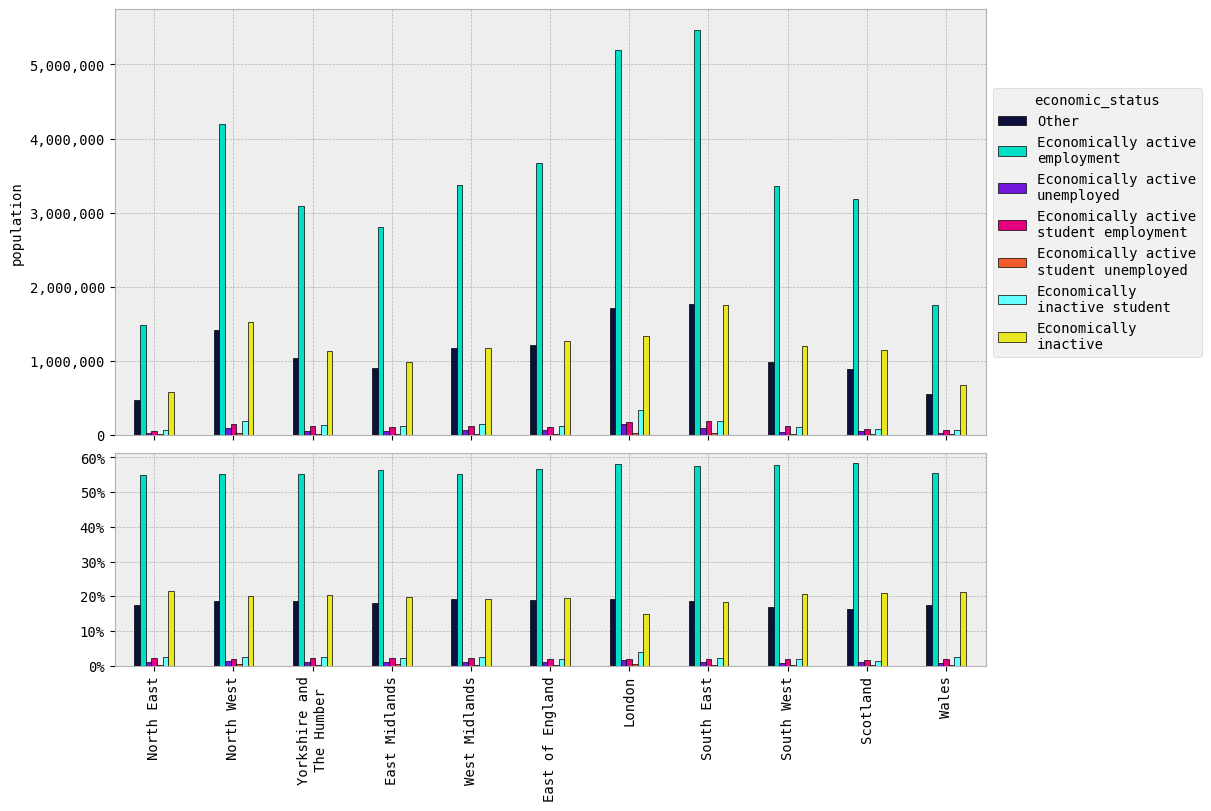

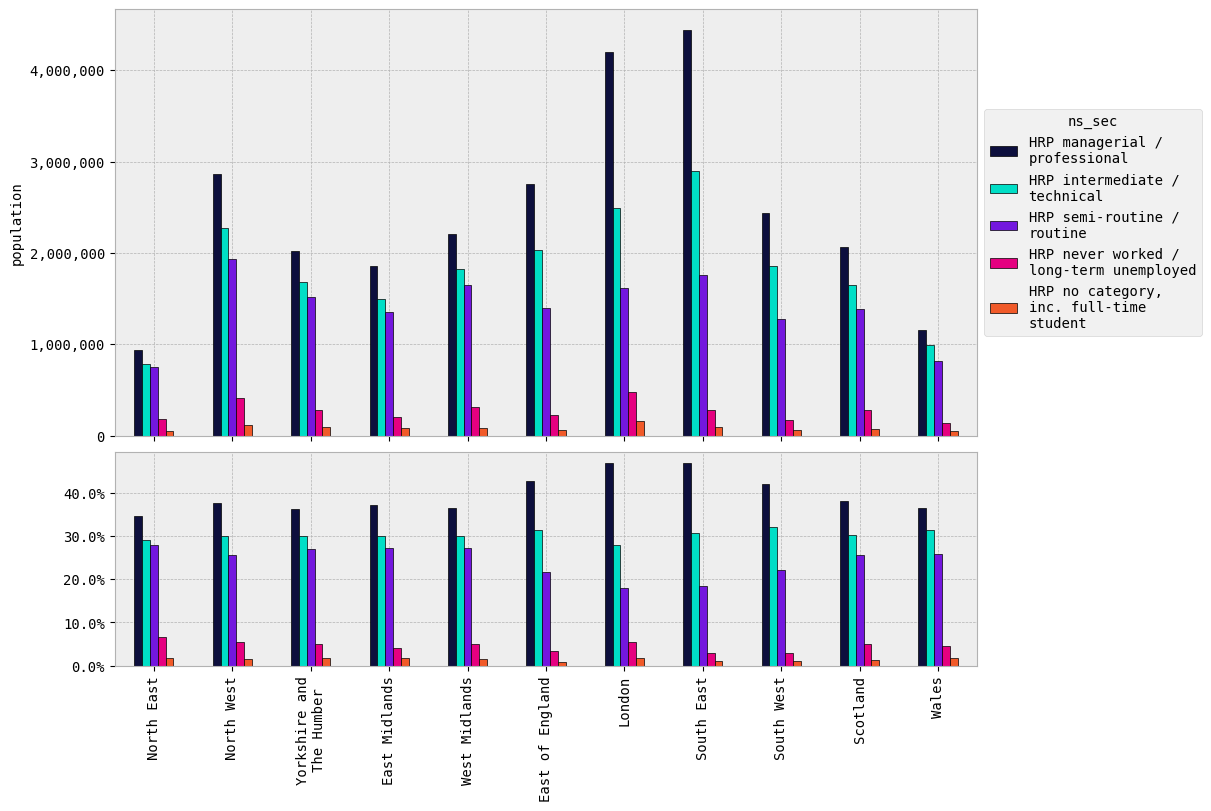

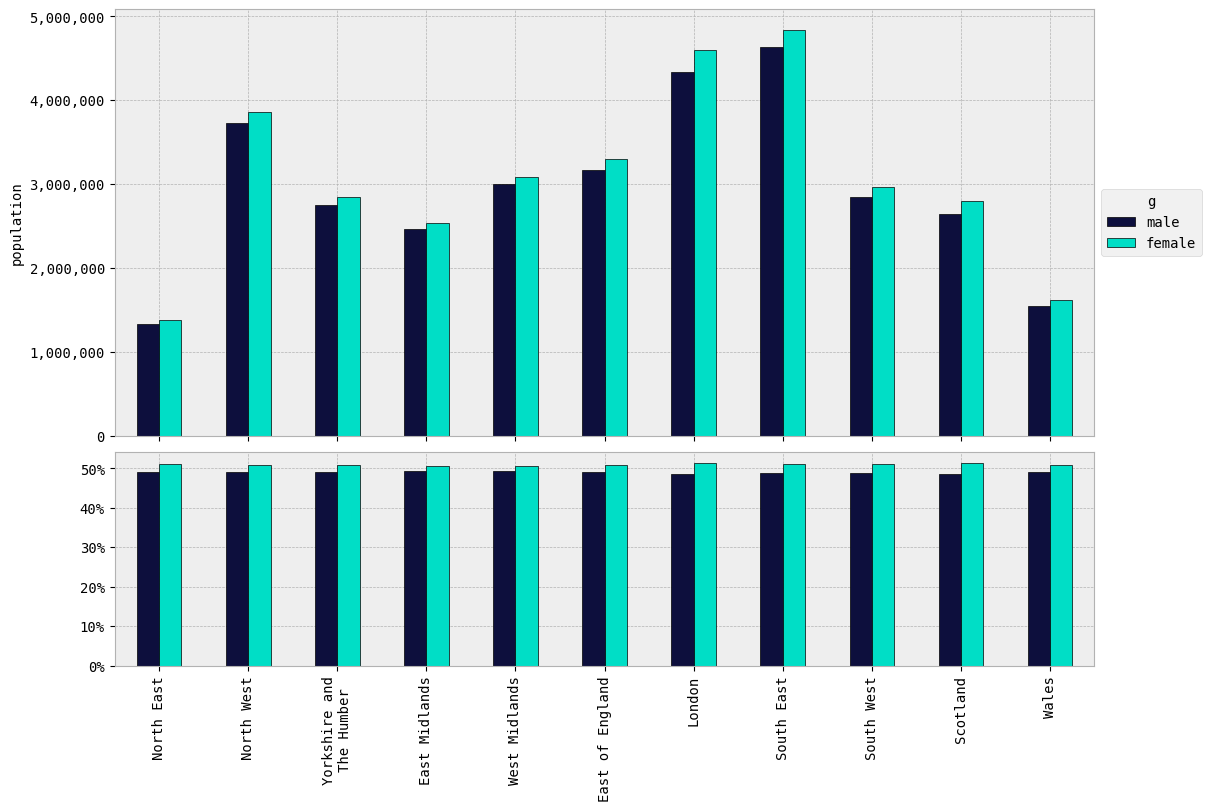

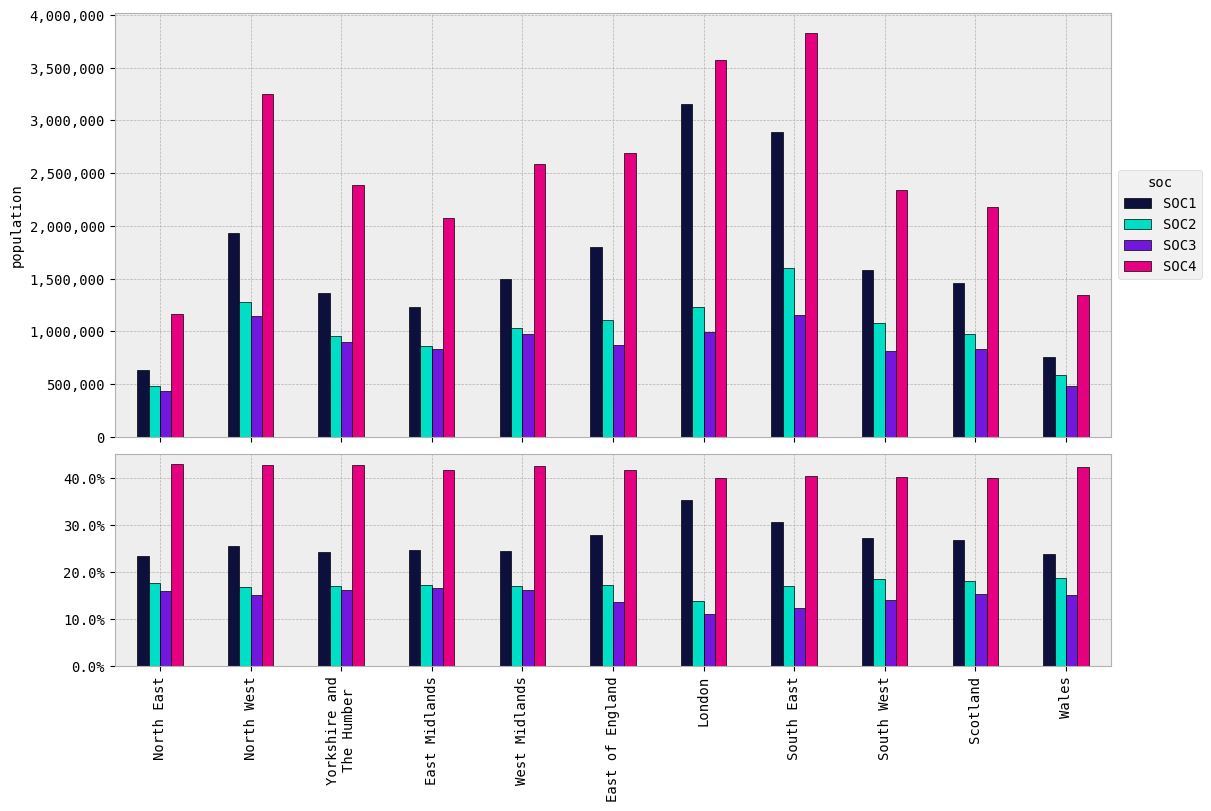

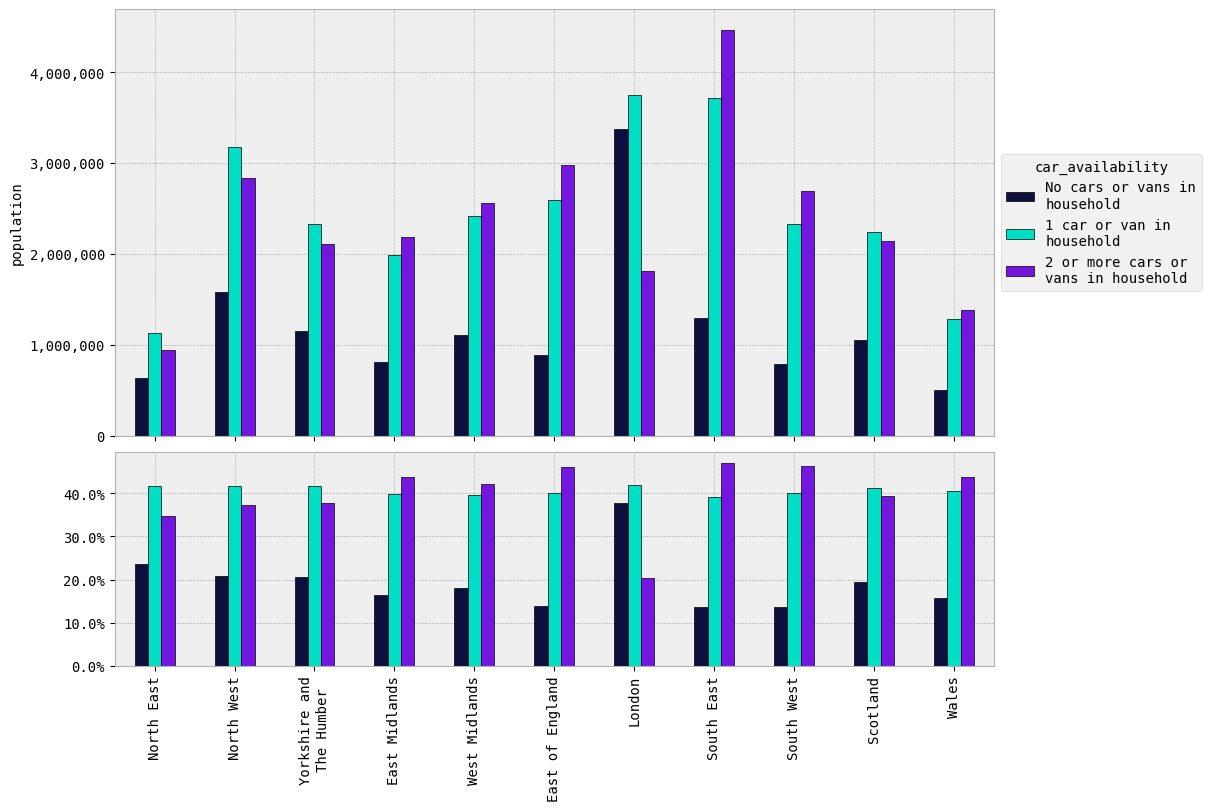

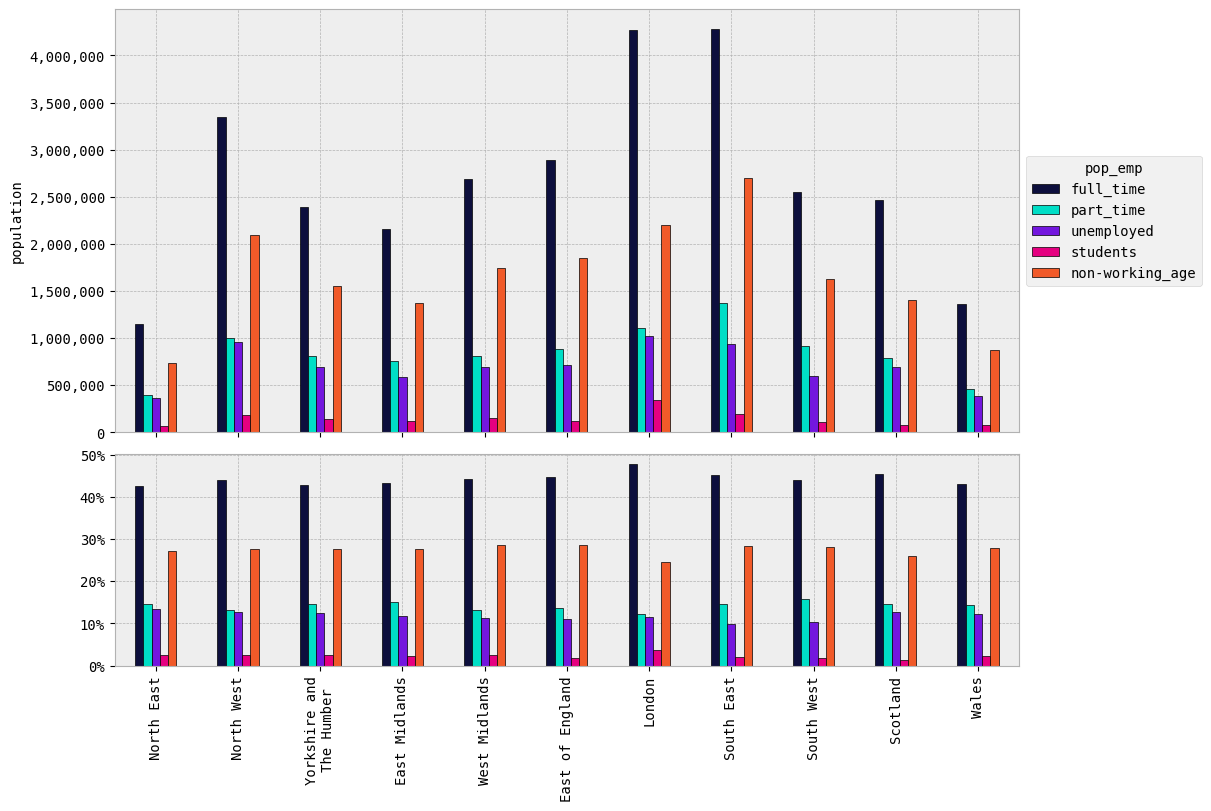

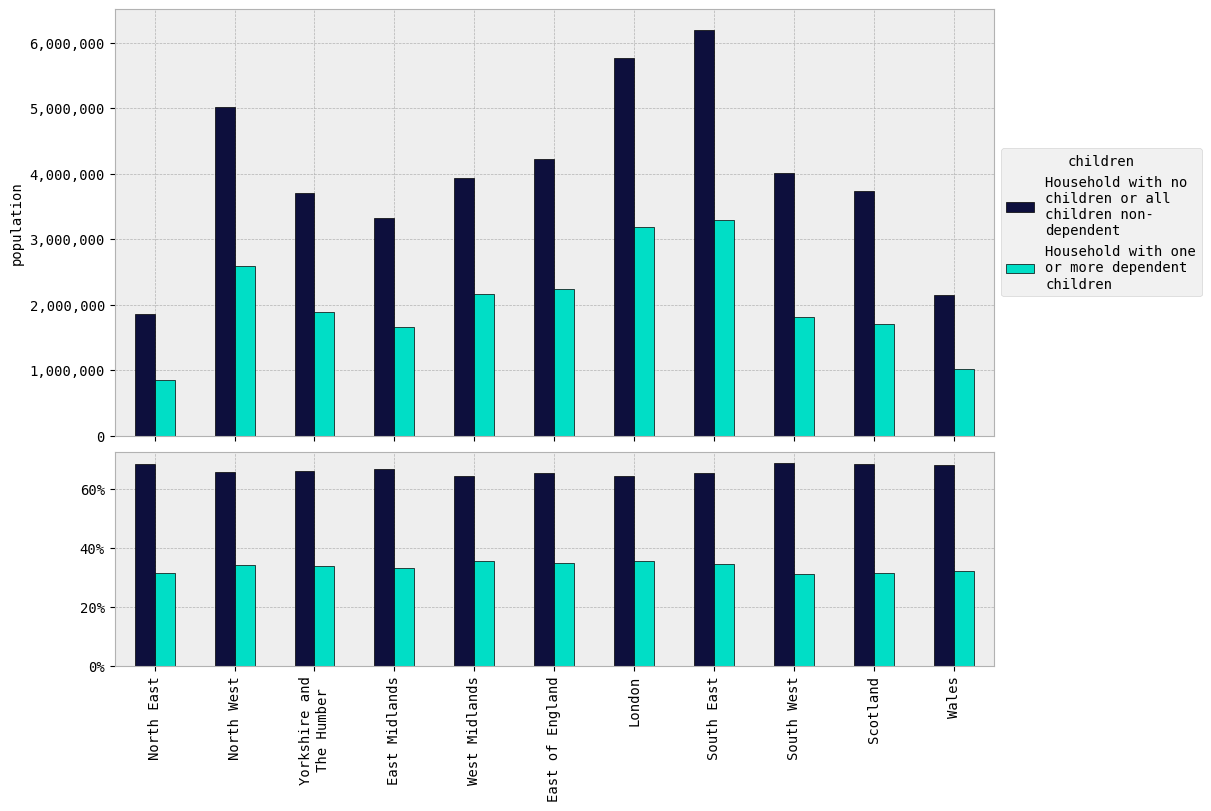

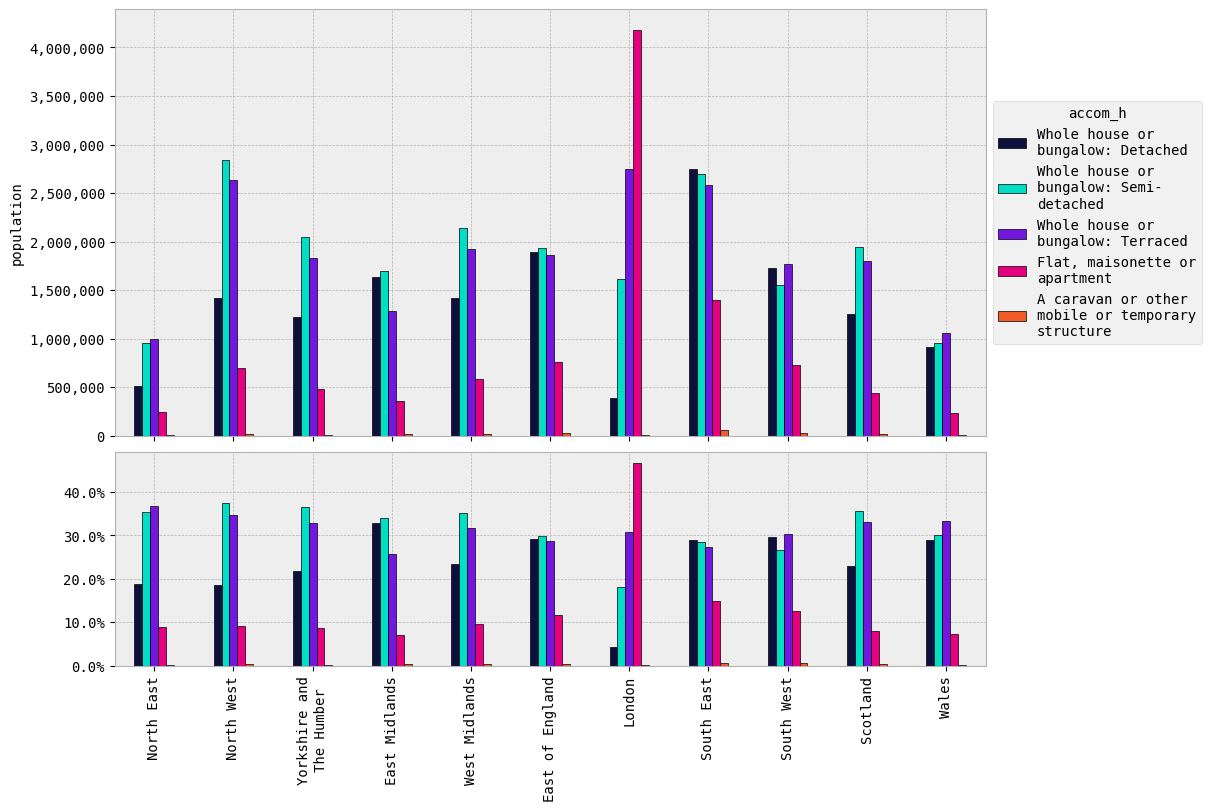

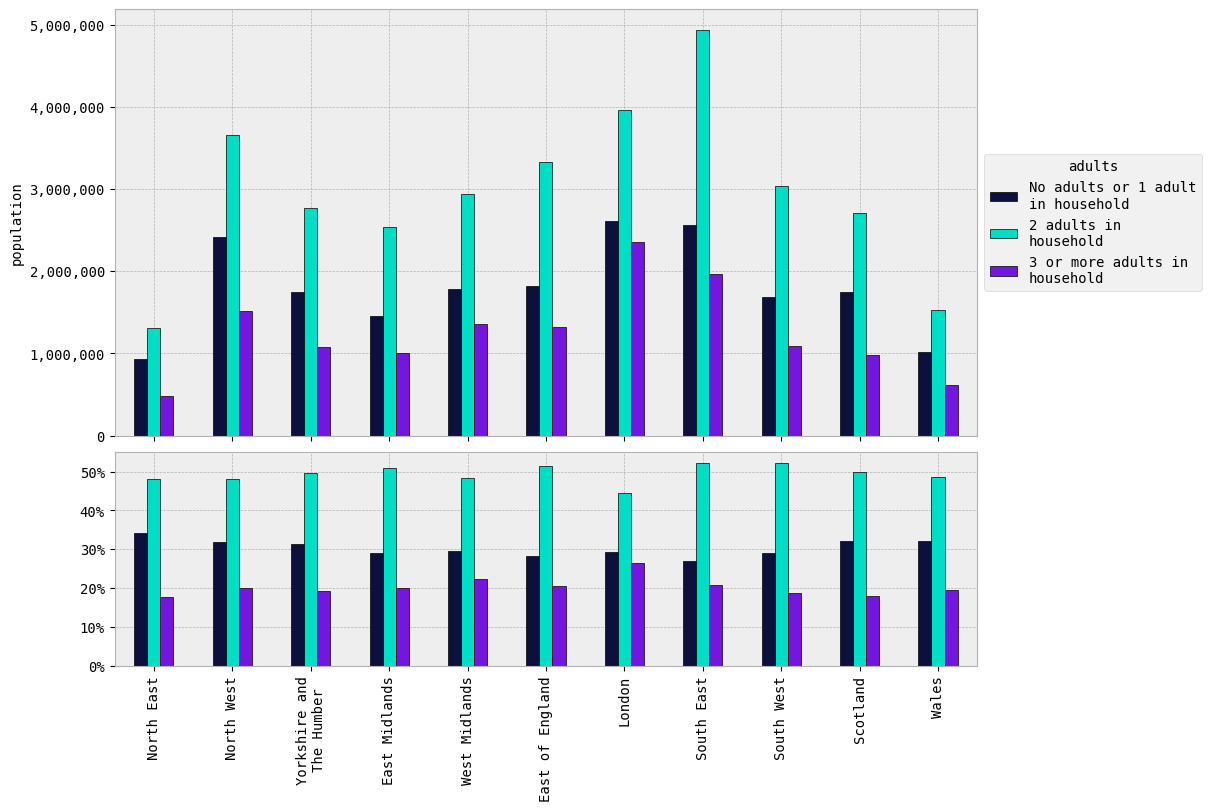

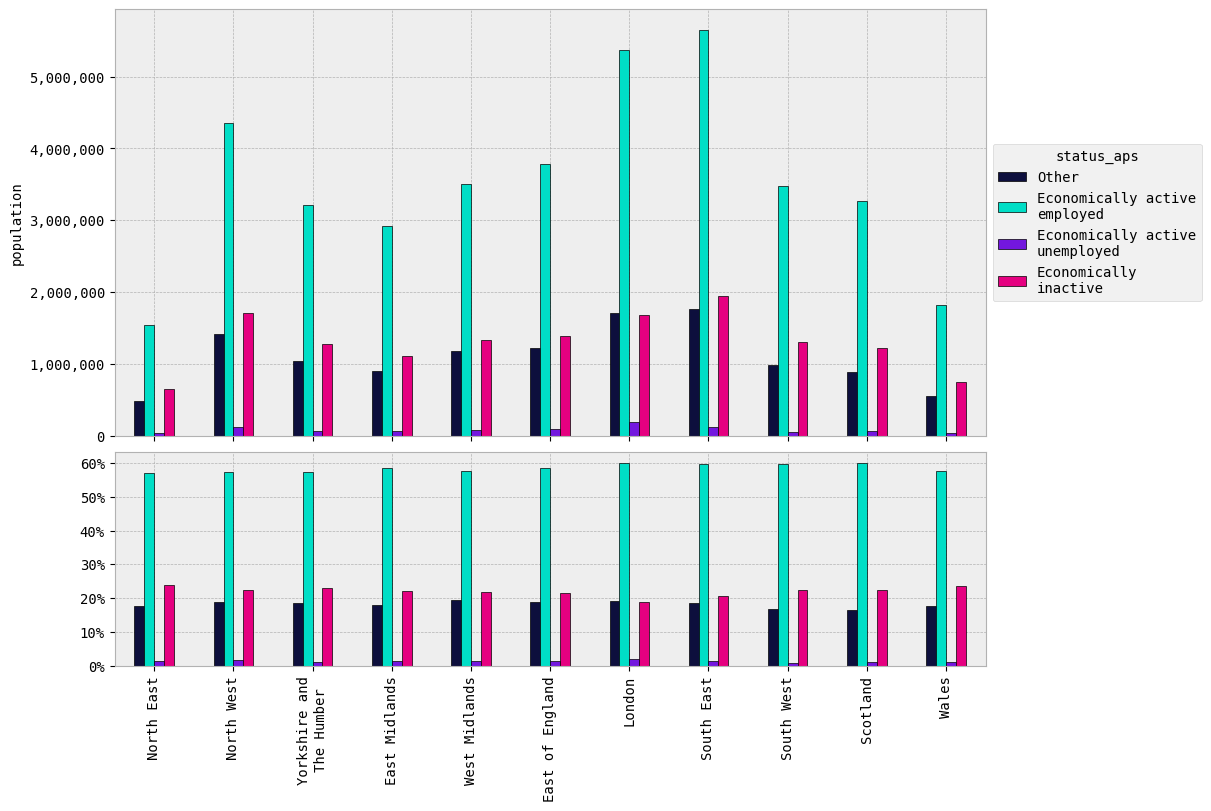

In [21]:
for seg in totals.segmentation.names:

    # get category names within the segmentation to help readability of charts
    segment_mapping = totals.segmentation.seg_dict[seg].values

    # find out how many categories and dont plot if there's too many
    if len(segment_mapping.values()) > max_segments:
        continue

    # group data by the specific segment (plotting only one at a time)
    data = totals.aggregate([seg]).data.T

    # change the index and column values to zone names and category names, respectively
    data.index = data.index.map(mapping)
    data.columns = data.columns.map(segment_mapping)

    # Write out summary csv
    data.to_csv(output_path / f'{seg}-{unit}-region.csv', float_format='%.0f')

    # And now *after* we've written, shorten labels for graph
    data.index = data.index.map(lambda f: fill(f, 15))
    data.columns = data.columns.map(lambda f: fill(f, 20))

    percentages = data.copy()
    percentages = percentages.div(percentages.sum(axis=1), axis=0)

    fig, axes = plt.subplots(figsize=(12, 8), nrows=2, sharex=True, sharey=False, gridspec_kw=dict(height_ratios=[2, 1]))

    # plot grouped bar chart
    data.plot.bar(zorder=2, ax=axes[0], edgecolor='black')
    # labels = [fill(l, 20) for l in data.columns]
    axes[0].set_ylabel(unit)
    axes[0].yaxis.set_major_formatter(
        matplotlib.ticker.FuncFormatter(lambda x, p: format(int(x), ','))
    )
    axes[0].legend(title=seg, loc='center left', bbox_to_anchor=(1, 0.5))

    percentages.plot.bar(zorder=2, ax=axes[1], legend=False, edgecolor='black')
    axes[1].yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(xmax=1))
    axes[1].set_xlabel(None)
    
    # save output file
    plt.savefig(output_path / f'{seg}-{unit}-region.png')